### Imports

In [1]:
# ==========================================
# Imports
# ==========================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


### Load Dataset

In [2]:
# ==========================================
# Load fraud network dataset
# ==========================================

df = pd.read_csv("fraud_network_50000.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (50000, 16)


,beneficiary_id,aadhaar_like_id,name,household_id,district,phone_number,bank_account,agent_id,registration_day,phone_degree,bank_degree,household_size,agent_cluster_size,is_duplicate,fraud_ring_member,is_master_agent
0,B000000,100000015795,Priya,HH24063,District_19,9820019110,BA97523830,AG0550,154,1,3,1,12,1,1,1
1,B000001,100000000860,Sneha,HH11793,District_10,9294445623,BA74975266,AG2523,75,1,1,1,12,1,1,1
2,B000002,100000038158,Vikram,HH17712,District_16,9684589693,BA35160821,AG3712,205,2,2,2,15,1,1,1
3,B000003,100000044732,Pooja,HH11456,District_4,9333105192,BA47796442,AG2506,328,3,2,2,9,1,1,0
4,B000004,100000011284,Pooja,HH25453,District_6,9567801705,BA19682218,AG2307,137,3,2,2,13,1,1,1


### Basic Data Checks

In [3]:
# ==========================================
# Missing values & data types
# ==========================================

print("\nMissing values:\n")
print(df.isnull().sum())

print("\nData types:\n")
print(df.dtypes)


Missing values:

beneficiary_id        0
aadhaar_like_id       0
name                  0
household_id          0
district              0
phone_number          0
bank_account          0
agent_id              0
registration_day      0
phone_degree          0
bank_degree           0
household_size        0
agent_cluster_size    0
is_duplicate          0
fraud_ring_member     0
is_master_agent       0
dtype: int64

Data types:

beneficiary_id        object
aadhaar_like_id        int64
name                  object
household_id          object
district              object
phone_number           int64
bank_account          object
agent_id              object
registration_day       int64
phone_degree           int64
bank_degree            int64
household_size         int64
agent_cluster_size     int64
is_duplicate           int64
fraud_ring_member      int64
is_master_agent        int64
dtype: object


### Define Features & Target

In [4]:
# ==========================================
# Feature / target split
# ==========================================

target = "fraud_ring_member"

feature_cols = [
    "phone_degree",
    "bank_degree",
    "household_size",
    "agent_cluster_size"
]

X = df[feature_cols]
y = df[target]

print("Target distribution:\n", y.value_counts())


Target distribution:
 fraud_ring_member
1    49621
0      379
Name: count, dtype: int64


### Correlation Analysis

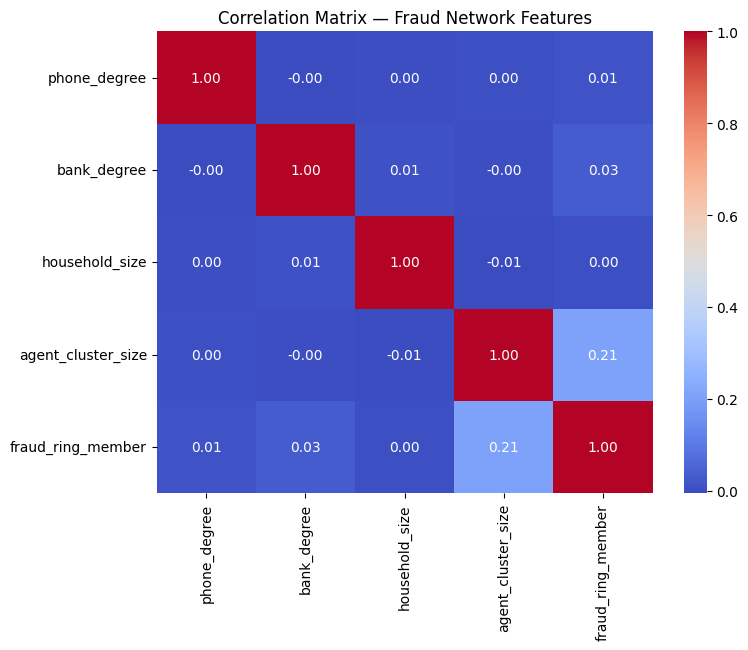

In [5]:
# ==========================================
# Correlation heatmap
# ==========================================

corr = df[feature_cols + [target]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix — Fraud Network Features")
plt.show()


### Train-Test Split

In [6]:
# ==========================================
# Train-test split
# ==========================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (40000, 4)
Test size: (10000, 4)


### Train Model (Random Forest)

In [7]:
# ==========================================
# Train Random Forest model
# ==========================================

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("✅ Model training completed")


✅ Model training completed


### Predictions

In [8]:
# ==========================================
# Predictions
# ==========================================

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

### Evaluation Metrics

In [9]:
# ==========================================
# Evaluation
# ==========================================

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))
print("ROC-AUC:", round(roc_auc, 4))

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Accuracy: 1.0
ROC-AUC: 1.0

Confusion Matrix:
 [[  76    0]
 [   0 9924]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00      9924

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### ROC Curve

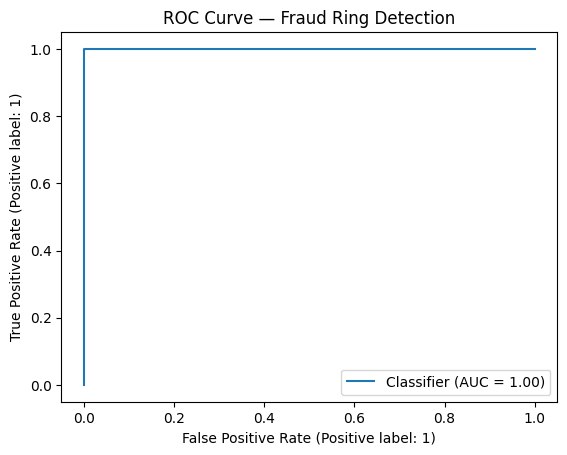

In [10]:
# ==========================================
# ROC Curve
# ==========================================

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve — Fraud Ring Detection")
plt.show()

### Feature Importance

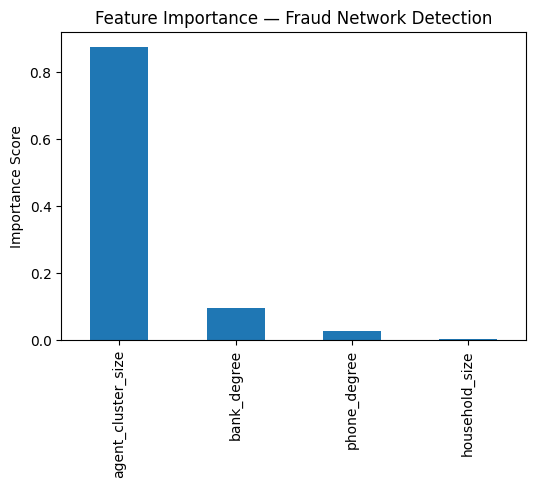

agent_cluster_size    0.876888
bank_degree           0.095369
phone_degree          0.025525
household_size        0.002217
dtype: float64

In [11]:
# ==========================================
# Feature importance
# ==========================================

importances = pd.Series(model.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
importances.plot(kind="bar")
plt.title("Feature Importance — Fraud Network Detection")
plt.ylabel("Importance Score")
plt.show()

importances


### Test with Manual samples

In [12]:
normal_sample = pd.DataFrame([{
    "phone_degree": 1,
    "bank_degree": 1,
    "household_size": 3,
    "agent_cluster_size": 1
}])

pred = model.predict(normal_sample)[0]
prob = model.predict_proba(normal_sample)[0][1]

print("Prediction:", "Fraud Ring" if pred == 1 else "Normal")
print("Fraud Probability:", round(prob * 100, 2), "%")


Prediction: Normal
Fraud Probability: 0.0 %


### Fraud Sample

In [13]:
fraud_sample = pd.DataFrame([{
    "phone_degree": 8,
    "bank_degree": 6,
    "household_size": 5,
    "agent_cluster_size": 12
}])

pred = model.predict(fraud_sample)[0]
prob = model.predict_proba(fraud_sample)[0][1]

print("Prediction:", "Fraud Ring" if pred == 1 else "Normal")
print("Fraud Probability:", round(prob * 100, 2), "%")


Prediction: Fraud Ring
Fraud Probability: 100.0 %


### Save Model 

In [14]:
# ==========================================
# Save trained model
# ==========================================

joblib.dump(model, "fraud_network_model.pkl")

print("✅ Model saved as fraud_network_model.pkl")


✅ Model saved as fraud_network_model.pkl
